##### Copyright 2019 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Convolutional Neural Network (CNN)

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/images/cnn">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/cnn.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/cnn.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/images/cnn.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial demonstrates training a simple [Convolutional Neural Network](https://developers.google.com/machine-learning/glossary/#convolutional_neural_network) (CNN) to classify [CIFAR images](https://www.cs.toronto.edu/~kriz/cifar.html). Because this tutorial uses the [Keras Sequential API](https://www.tensorflow.org/guide/keras/overview), creating and training your model will take just a few lines of code.


### Import TensorFlow

In [1]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

### Download and prepare the CIFAR10 dataset


The CIFAR10 dataset contains 60,000 color images in 10 classes, with 6,000 images in each class. The dataset is divided into 50,000 training images and 10,000 testing images. The classes are mutually exclusive and there is no overlap between them.

In [2]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

170498071/170498071 [==============================] - 2s 0us/step


### Verify the data

To verify that the dataset looks correct, let's plot the first 25 images from the training set and display the class name below each image:


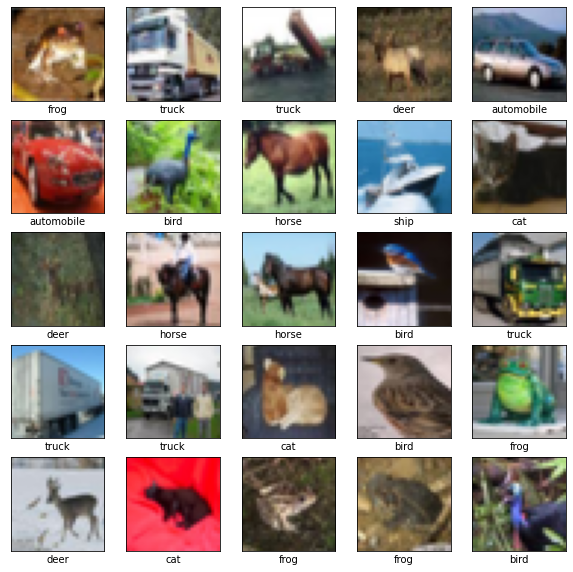

In [3]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

### Create the convolutional base

The 6 lines of code below define the convolutional base using a common pattern: a stack of [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) and [MaxPooling2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D) layers.

As input, a CNN takes tensors of shape (image_height, image_width, color_channels), ignoring the batch size. If you are new to these dimensions, color_channels refers to (R,G,B). In this example, you will configure your CNN to process inputs of shape (32, 32, 3), which is the format of CIFAR images. You can do this by passing the argument `input_shape` to your first layer.


In [4]:
from keras.datasets import cifar10
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import BatchNormalization
model = models.Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(10, activation='relu'))

Let's display the architecture of your model so far:

In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                        

Above, you can see that the output of every Conv2D and MaxPooling2D layer is a 3D tensor of shape (height, width, channels). The width and height dimensions tend to shrink as you go deeper in the network. The number of output channels for each Conv2D layer is controlled by the first argument (e.g., 32 or 64). Typically,  as the width and height shrink, you can afford (computationally) to add more output channels in each Conv2D layer.

### Add Dense layers on top

To complete the model, you will feed the last output tensor from the convolutional base (of shape (4, 4, 64)) into one or more Dense layers to perform classification. Dense layers take vectors as input (which are 1D), while the current output is a 3D tensor. First, you will flatten (or unroll) the 3D output to 1D,  then add one or more Dense layers on top. CIFAR has 10 output classes, so you use a final Dense layer with 10 outputs.

Here's the complete architecture of your model:

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 4, 4, 64)          36928     
                                                                 
 flatten_2 (Flatten)         (None, 1024)             

The network summary shows that (4, 4, 64) outputs were flattened into vectors of shape (1024) before going through two Dense layers.

In [6]:
from tensorflow.keras.optimizers import SGD
opt = SGD(learning_rate=0.001, momentum=0.9)

### Compile and train the model

In [7]:
model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=200, 
                    validation_data=(test_images, test_labels))

Epoch 1/200
1563/1563 [==============================] - 22s 8ms/step - loss: 1.9508 - accuracy: 0.3330 - val_loss: 1.4773 - val_accuracy: 0.4563
Epoch 2/200
1563/1563 [==============================] - 12s 7ms/step - loss: 1.4783 - accuracy: 0.4759 - val_loss: 1.2718 - val_accuracy: 0.5452
Epoch 3/200
1563/1563 [==============================] - 11s 7ms/step - loss: 1.2969 - accuracy: 0.5393 - val_loss: 1.1874 - val_accuracy: 0.5767
Epoch 4/200
1563/1563 [==============================] - 11s 7ms/step - loss: 1.1864 - accuracy: 0.5845 - val_loss: 1.0426 - val_accuracy: 0.6263
Epoch 5/200
1563/1563 [==============================] - 11s 7ms/step - loss: 1.1055 - accuracy: 0.6114 - val_loss: 0.9933 - val_accuracy: 0.6501
Epoch 6/200
1563/1563 [==============================] - 12s 8ms/step - loss: 1.0503 - accuracy: 0.6333 - val_loss: 0.9531 - val_accuracy: 0.6603
Epoch 7/200
1563/1563 [==============================] - 11s 7ms/step - loss: 1.0013 - accuracy: 0.6500 - val_loss: 0.9181 -

### Evaluate the model

313/313 - 1s - loss: 0.4774 - accuracy: 0.8712 - 941ms/epoch - 3ms/step


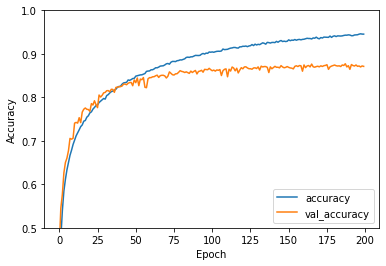

In [8]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

In [9]:
print(test_acc)

0.8712000250816345


Your simple CNN has achieved a test accuracy of over 70%. Not bad for a few lines of code! For another CNN style, check out the [TensorFlow 2 quickstart for experts](https://www.tensorflow.org/tutorials/quickstart/advanced) example that uses the Keras subclassing API and `tf.GradientTape`.

In [13]:
model.save('saved_model/8_CIFRmodel.h5')

In [14]:
ls saved_model

8_CIFRmodel.h5


In [19]:
from keras.models import load_model
model = load_model('saved_model/8_CIFRmodel.h5')
def load_image(filename):
  img = load_img(filename, target_size=(32, 32))
  img = img_to_array(img)
  img = img.reshape(1, 32, 32, 3)
  img = img / 255.0
  return img

In [20]:
#https://stackoverflow.com/questions/72479044/cannot-import-name-load-img-from-keras-preprocessing-image
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
from keras.models import load_model

1/1 [==============================] - 0s 15ms/step

Predicition: This image likely belongs to cat


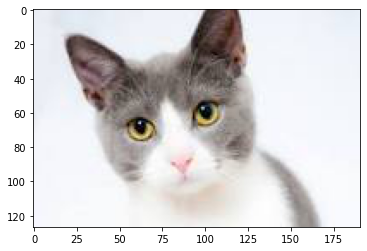

In [24]:
URL = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRatRLG5NHqJrhz9Gm95iD81IgRLN5_kVLn9jDGsyc-&s"
picture_path  = tf.keras.utils.get_file(origin=URL)
img = load_image(picture_path)
result = model.predict(img)

image = plt.imread(picture_path)
plt.imshow(image)

print('\nPredicition: This image likely belongs to ' + class_names[int(result.argmax(axis=-1))])

1/1 [==============================] - 0s 92ms/step

Predicition: This image likely belongs to bird


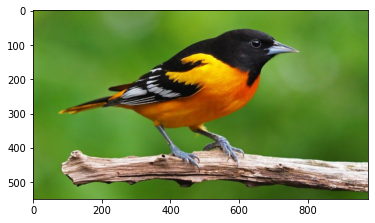

In [25]:
URL = "https://ichef.bbci.co.uk/news/976/cpsprodpb/67CF/production/_108857562_mediaitem108857561.jpg"
picture_path  = tf.keras.utils.get_file(origin=URL)
img = load_image(picture_path)
result = model.predict(img)

image = plt.imread(picture_path)
plt.imshow(image)

print('\nPredicition: This image likely belongs to ' + class_names[int(result.argmax(axis=-1))])

1/1 [==============================] - 0s 18ms/step

Predicition: This image likely belongs to airplane


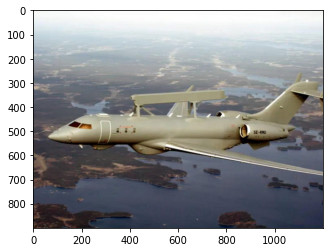

In [27]:
URL = "https://www.zdnet.com/a/img/resize/071727877ee9884b60edd728253d2baadcb3985f/2021/02/23/19631992-64df-4af9-a288-a0cb4112e682/bombardier-globaleye-jet.jpg?width=1200&height=900&fit=crop&auto=webp"
picture_path  = tf.keras.utils.get_file(origin=URL)
img = load_image(picture_path)
result = model.predict(img)

image = plt.imread(picture_path)
plt.imshow(image)

print('\nPredicition: This image likely belongs to ' + class_names[int(result.argmax(axis=-1))])

1/1 [==============================] - 0s 16ms/step

Predicition: This image likely belongs to automobile


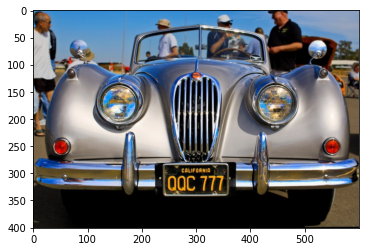

In [28]:
URL = "https://images.all-free-download.com/images/graphiclarge/classic_jaguar_210354.jpg"
picture_path  = tf.keras.utils.get_file(origin=URL)
img = load_image(picture_path)
result = model.predict(img)

image = plt.imread(picture_path)
plt.imshow(image)

print('\nPredicition: This image likely belongs to ' + class_names[int(result.argmax(axis=-1))])

1/1 [==============================] - 0s 16ms/step

Predicition: This image likely belongs to cat


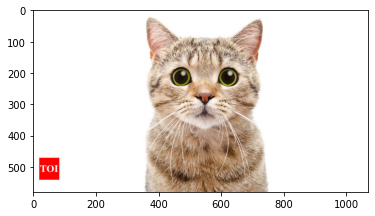

In [29]:
URL = "https://static.toiimg.com/thumb/msid-67586673,width-1070,height-580,overlay-toi_sw,pt-32,y_pad-40,resizemode-75,imgsize-3918697/67586673.jpg"
picture_path  = tf.keras.utils.get_file(origin=URL)
img = load_image(picture_path)
result = model.predict(img)

image = plt.imread(picture_path)
plt.imshow(image)

print('\nPredicition: This image likely belongs to ' + class_names[int(result.argmax(axis=-1))])

1/1 [==============================] - 0s 17ms/step

Predicition: This image likely belongs to bird


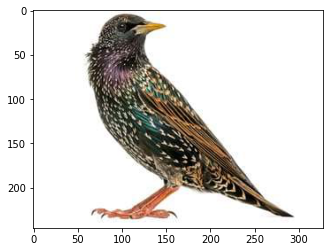

In [32]:
URL = "https://www.pestworld.org/media/560900/istock_000027713740_large.jpg?preset=pestFeature360"
picture_path  = tf.keras.utils.get_file(origin=URL)
img = load_image(picture_path)
result = model.predict(img)

image = plt.imread(picture_path)
plt.imshow(image)

print('\nPredicition: This image likely belongs to ' + class_names[int(result.argmax(axis=-1))])